# t-SNE with CUDA acceleration

Run t-SNE over sets of images using the CannyLab tsne-cuda implementation: https://github.com/CannyLab/tsne-cuda

Requires that feature vectors have already been extracted from images and these pickled.

In [1]:
import os
import random
import pickle
import time
import datetime
import bz2
import uuid

In [2]:
from tsnecuda import TSNE

ModuleNotFoundError: No module named 'tsnecuda'

In [2]:
from sklearn.manifold import TSNE

In [3]:
from PIL import Image
# from pillow import Image

In [4]:
from matplotlib.pyplot import imshow

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

from matplotlib.pyplot import imshow

In [5]:
import rasterfairy

In [45]:
perp = 50
bPCA = True
num_iterations = 2000
num_samples = 300

In [7]:
pickle_folder = '/home/rte/re-imaging/visualisation/'

paths = []

for file in os.listdir(pickle_folder):
    if file.endswith(".pickle") and file.startswith("features"):
        paths.append(os.path.join(pickle_folder, file))
paths.sort()
# print(paths)

print("----- list of all paths: ")
for p in paths:
    print(p)
print("----------")

----- list of all paths: 
/home/rte/re-imaging/visualisation/features_csAI_all2012_vgg_x1669.pickle
/home/rte/re-imaging/visualisation/features_csAI_montage_144_all2012_vgg_x1669.pickle
/home/rte/re-imaging/visualisation/features_statML_all2012_vgg_x2889.pickle
----------


In [ ]:
# loop here

for p in paths[]:
    print(p)
    
    category = p.split('_')[1]
    year = p.split('_')[2]
    print("category: " + category)
    print("year: " + str(year))

    with open(p, "rb") as read_file:
        images, features = pickle.load(read_file)
        read_file.close()
    
    # check that we still have the features and list of images
    print("----- checking images and features -----")
    print("length of images: " + str(len(images)))
    print("length of features: " + str(len(features)))
    for img, f in list(zip(images, features))[0:5]:
        print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(img, f[0], f[1], f[2], f[3]))
    
#     if len(images) >= 300:
    if True:
        features = np.array(features)
        print("----- running pca across features -----")
        print(features.shape)
        print("number of samples: ", np.size(features, 0))
        pca = PCA(n_components=min(np.size(features,0), 300))
        pca.fit(features)

        pca_features = pca.transform(features)
        
        print("----- pca done -----")
        
        print("----- running tSNE -----")

        X = np.array(pca_features)
        print(X.shape)
        tsne = TSNE(n_components=2, learning_rate=150, perplexity=perp, verbose=2, n_iter=num_iterations).fit_transform(X)
        print(tsne.shape)
        
        print("----- tSNE done -----")

        # write pickle
        print("writing tsne pickle")
        
        ts = time.time()
        st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d_%H-%M-%S')
        
        filename = "tSNE_cuda_" + category + "_" + year + "_n" + str(num_iterations) + "_p" + str(perp) + "_" + st
        print(filename + ".pickle")
        
        with open(filename + ".pickle", "wb") as write_file:
            pickle.dump([images, tsne], write_file)
            write_file.close()
            
        # normalise points
        tx, ty = tsne[:,0], tsne[:,1]
        tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
        ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

        width = 4000
        height = 3000
        max_dim = 100
        
        print("----- creating image from tiles -----")

        full_image = Image.new('RGBA', (width, height))
        for img, x, y in zip(images, tx, ty):
            tile = Image.open(img)
            tw = tile.width
            th = tile.height
#             print(img)
#             print("tile dimensions: x=" + str(tile.width) + " y=" + str(tile.height))
            if tw < 10000 and th < 10000:
                rs = max(1, tw/max_dim, th/max_dim)
                tile = tile.resize((int(tw/rs), int(th/rs)), Image.ANTIALIAS)
                full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))
#             else:
#                 print("tile width or height too big?")
                
        plt.figure(figsize = (16,12))
        imshow(full_image)


        print("saved file: " + filename + ".png")
        full_image.save(filename + ".png")
        print("----- finished! file saved -----")

    else:
        print("selected dataset has less than 300 items")
            


New version with different pickles

In [8]:
p = "/home/rte/re-imaging/visualisation/features/v1/features_0_50000_vgg.pkl.pbz2"
folder = "/home/rte/re-imaging/visualisation/features/v1/"

features_load = []
files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
files.sort()
# print(files)

for f in files[:2]:
    with bz2.open(folder + f, "r") as read_file:
        features_load = features_load + pickle.load(read_file)
        print("loaded:", folder + f)
        print("features size:",len(features_load))
#     for p in features[:5]:
#         print(p)

loaded: /home/rte/re-imaging/visualisation/features/v1/features_0_50000_vgg.pkl.pbz2
features size: 50000
loaded: /home/rte/re-imaging/visualisation/features/v1/features_100000_150000_vgg.pkl.pbz2
features size: 100000


In [9]:
images = []

with open("/home/rte/data/paths/all_converted_jpg_images_shuf.txt", "r") as f:
    lines = f.readlines()
    print("length:",len(lines))
    print(lines[0])
for l in lines:
    # substrings = l.rsplit(",", 1)
    images.append(l.strip())
    # image_ids.append(substrings[1].strip())

length: 10052503
2971229.jpg



----- running pca across features -----
features shape: (5000, 4096)
number of samples:  5000
----- pca done -----
----- running tSNE -----
X shape: (5000, 300)
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.061s...
[t-SNE] Computed neighbors for 5000 samples in 11.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 15.363301
[t-SNE] Computed conditional probabilities in 0.333s
[t-SNE] Iteration 50: error = 80.8804398, gradient norm = 0.0000003 (50 iterations in 1.735s)
[t-SNE] Iteration 100: error = 80.8804398, gradient norm = 0.0000108 (50 iterations in 1.202s)
[t-SNE] Iteration 150: error = 80.8800735, gradient norm = 0.0002313 (50 iterations in 1.455s)

[t-SNE] Iteration 4000: error = 2.2542019, gradient norm = 0.0000112 (50 iterations in 1.560s)
[t-SNE] KL divergence after 4000 iterations: 2.254202
t-SNE shape: (5000, 2)
----- tSNE done -----
tx shape: (5000,)
ty shape: (5000,)
tx sample: [0.41298288 0.48182446 0.59429616 0.87410027 0.4812638  0.53984064
 0.3789693  0.35074228 0.02807992 0.674574   0.4900844  0.68586487
 0.8733177  0.49172068 0.43361777 0.08391124 0.1747617  0.2391832
 0.699431   0.5052223  0.42379063 0.5017082  0.32289496 0.8117877
 0.34703186 0.14777744 0.49156934 0.48259664 0.4936926  0.06317906
 0.1393278  0.12295371 0.4841255  0.34269425 0.80354714 0.7727449
 0.32176152 0.52979136 0.3856302  0.8897316  0.43387124 0.15647647
 0.48331726 0.889119   0.9140923  0.90164566 0.42243537 0.19610274
 0.57346576 0.6018993 ]
ty sample: [0.330484   0.17826325 0.23622443 0.42617846 0.4252451  0.28813154
 0.24275121 0.9050321  0.6998215  0.4555718  0.6001787  0.46228752
 0.49594674 0.36483407 0.41085064 0.5076762  0.540766   0

-----
count: 73
tw: 713
th: 512
8000261.jpg
tile dimensions: x=713 y=512
image placement: x=476 y=2207
-----
count: 74
tw: 517
th: 512
4394542.jpg
tile dimensions: x=517 y=512
image placement: x=3137 y=1782
-----
count: 75
tw: 512
th: 520
3532949.jpg
tile dimensions: x=512 y=520
image placement: x=1783 y=1839
-----
count: 76
tw: 2012
th: 512
2847097.jpg
tile dimensions: x=2012 y=512
image placement: x=1253 y=1397
-----
count: 77
tw: 1002
th: 512
5747040.jpg
tile dimensions: x=1002 y=512
image placement: x=816 y=1880
-----
count: 78
tw: 513
th: 512
8320931.jpg
tile dimensions: x=513 y=512
image placement: x=3193 y=695
-----
count: 79
tw: 554
th: 512
6733640.jpg
tile dimensions: x=554 y=512
image placement: x=2139 y=1593
-----
count: 80
tw: 512
th: 680
7562197.jpg
tile dimensions: x=512 y=680
image placement: x=1889 y=412
-----
count: 81
tw: 646
th: 498
820079.jpg
tile dimensions: x=646 y=498
image placement: x=3299 y=2346
-----
count: 82
tw: 512
th: 647
8989816.jpg
tile dimensions: x=51

-----
count: 180
tw: 1408
th: 512
9771524.jpg
tile dimensions: x=1408 y=512
image placement: x=3454 y=1657
-----
count: 181
tw: 842
th: 512
8289086.jpg
tile dimensions: x=842 y=512
image placement: x=2577 y=913
-----
count: 182
tw: 512
th: 718
183789.jpg
tile dimensions: x=512 y=718
image placement: x=1931 y=457
-----
count: 183
tw: 549
th: 512
2037676.jpg
tile dimensions: x=549 y=512
image placement: x=1885 y=2303
-----
count: 184
tw: 668
th: 512
6589056.jpg
tile dimensions: x=668 y=512
image placement: x=3105 y=1047
-----
count: 185
tw: 512
th: 883
3974658.jpg
tile dimensions: x=512 y=883
image placement: x=1337 y=1146
-----
count: 186
tw: 766
th: 488
1973730.jpg
tile dimensions: x=766 y=488
image placement: x=594 y=806
-----
count: 187
tw: 1269
th: 512
8666269.jpg
tile dimensions: x=1269 y=512
image placement: x=2755 y=515
-----
count: 188
tw: 665
th: 504
3129812.jpg
tile dimensions: x=665 y=504
image placement: x=2832 y=506
-----
count: 189
tw: 704
th: 512
9271638.jpg
tile dimensio

-----
count: 287
tw: 1001
th: 512
5822103.jpg
tile dimensions: x=1001 y=512
image placement: x=2083 y=2180
-----
count: 288
tw: 688
th: 512
3481080.jpg
tile dimensions: x=688 y=512
image placement: x=2788 y=577
-----
count: 289
tw: 512
th: 598
1576631.jpg
tile dimensions: x=512 y=598
image placement: x=1416 y=1156
-----
count: 290
tw: 689
th: 512
799999.jpg
tile dimensions: x=689 y=512
image placement: x=3213 y=537
-----
count: 291
tw: 1423
th: 512
332133.jpg
tile dimensions: x=1423 y=512
image placement: x=765 y=778
-----
count: 292
tw: 512
th: 532
5564994.jpg
tile dimensions: x=512 y=532
image placement: x=2086 y=1754
-----
count: 293
tw: 512
th: 560
5611853.jpg
tile dimensions: x=512 y=560
image placement: x=1324 y=925
-----
count: 294
tw: 512
th: 611
4492014.jpg
tile dimensions: x=512 y=611
image placement: x=1396 y=2744
-----
count: 295
tw: 760
th: 512
8985437.jpg
tile dimensions: x=760 y=512
image placement: x=1786 y=866
-----
count: 296
tw: 1932
th: 512
6547801.jpg
tile dimensio

image placement: x=1622 y=2345
-----
count: 394
tw: 703
th: 512
1257903.jpg
tile dimensions: x=703 y=512
image placement: x=2703 y=1364
-----
count: 395
tw: 1280
th: 512
103915.jpg
tile dimensions: x=1280 y=512
image placement: x=1801 y=2298
-----
count: 396
tw: 512
th: 1025
8836566.jpg
tile dimensions: x=512 y=1025
image placement: x=2069 y=1060
-----
count: 397
tw: 654
th: 512
5340839.jpg
tile dimensions: x=654 y=512
image placement: x=803 y=802
-----
count: 398
tw: 1074
th: 458
1113079.jpg
tile dimensions: x=1074 y=458
image placement: x=1268 y=1861
-----
count: 399
tw: 512
th: 693
6805652.jpg
tile dimensions: x=512 y=693
image placement: x=948 y=1583
-----
count: 400
tw: 667
th: 512
7807065.jpg
tile dimensions: x=667 y=512
image placement: x=3424 y=807
-----
count: 401
tw: 647
th: 512
2591579.jpg
tile dimensions: x=647 y=512
image placement: x=2868 y=566
-----
count: 402
tw: 512
th: 512
5930300.jpg
tile dimensions: x=512 y=512
image placement: x=922 y=2602
-----
count: 403
tw: 702


image placement: x=2849 y=596
-----
count: 502
tw: 375
th: 245
2504652.jpg
tile dimensions: x=375 y=245
image placement: x=519 y=1476
-----
count: 503
tw: 512
th: 657
1980531.jpg
tile dimensions: x=512 y=657
image placement: x=1364 y=2793
-----
count: 504
tw: 384
th: 794
497926.jpg
tile dimensions: x=384 y=794
image placement: x=2646 y=1817
-----
count: 505
tw: 512
th: 513
2404700.jpg
tile dimensions: x=512 y=513
image placement: x=1294 y=1709
-----
count: 506
tw: 983
th: 512
1897394.jpg
tile dimensions: x=983 y=512
image placement: x=2809 y=1444
-----
count: 507
tw: 31
th: 20
524191.jpg
tile dimensions: x=31 y=20
image placement: x=1790 y=2598
-----
count: 508
tw: 1115
th: 512
5849986.jpg
tile dimensions: x=1115 y=512
image placement: x=1273 y=2102
-----
count: 509
tw: 522
th: 512
9139290.jpg
tile dimensions: x=522 y=512
image placement: x=506 y=765
-----
count: 510
tw: 512
th: 920
926297.jpg
tile dimensions: x=512 y=920
image placement: x=1986 y=1160
-----
count: 511
tw: 522
th: 512


-----
count: 615
tw: 1235
th: 512
7360001.jpg
tile dimensions: x=1235 y=512
image placement: x=2821 y=1803
-----
count: 616
tw: 1093
th: 512
1687420.jpg
tile dimensions: x=1093 y=512
image placement: x=384 y=1608
-----
count: 617
tw: 476
th: 561
5257403.jpg
tile dimensions: x=476 y=561
image placement: x=1902 y=2465
-----
count: 618
tw: 700
th: 512
9917174.jpg
tile dimensions: x=700 y=512
image placement: x=3221 y=1810
-----
count: 619
tw: 224
th: 224
2850977.jpg
tile dimensions: x=224 y=224
image placement: x=1380 y=2770
-----
count: 620
tw: 512
th: 590
6152120.jpg
tile dimensions: x=512 y=590
image placement: x=1517 y=1926
-----
count: 621
tw: 805
th: 512
1428490.jpg
tile dimensions: x=805 y=512
image placement: x=3104 y=679
-----
count: 622
tw: 287
th: 160
3119307.jpg
tile dimensions: x=287 y=160
image placement: x=3039 y=1528
-----
count: 623
tw: 512
th: 522
7876556.jpg
tile dimensions: x=512 y=522
image placement: x=2634 y=1428
-----
count: 624
tw: 256
th: 256
681397.jpg
tile dime

image placement: x=793 y=2393
-----
count: 696
tw: 542
th: 512
7437628.jpg
tile dimensions: x=542 y=512
image placement: x=818 y=1054
-----
count: 697
tw: 266
th: 288
4789935.jpg
tile dimensions: x=266 y=288
image placement: x=3475 y=1652
-----
count: 698
tw: 678
th: 512
77055.jpg
tile dimensions: x=678 y=512
image placement: x=3446 y=1036
-----
count: 699
tw: 259
th: 154
2881908.jpg
tile dimensions: x=259 y=154
image placement: x=3063 y=1928
-----
count: 700
tw: 838
th: 512
3743996.jpg
tile dimensions: x=838 y=512
image placement: x=1057 y=2362
-----
count: 701
tw: 973
th: 512
27366.jpg
tile dimensions: x=973 y=512
image placement: x=3419 y=2061
-----
count: 702
tw: 844
th: 512
6853817.jpg
tile dimensions: x=844 y=512
image placement: x=2472 y=487
-----
count: 703
tw: 699
th: 512
79334.jpg
tile dimensions: x=699 y=512
image placement: x=1299 y=907
-----
count: 704
tw: 1379
th: 389
1157562.jpg
tile dimensions: x=1379 y=389
image placement: x=3169 y=1682
-----
count: 705
tw: 512
th: 544

th: 512
6368297.jpg
tile dimensions: x=950 y=512
image placement: x=1375 y=1422
-----
count: 808
tw: 1055
th: 208
6537959.jpg
tile dimensions: x=1055 y=208
image placement: x=822 y=2200
-----
count: 809
tw: 616
th: 512
6716908.jpg
tile dimensions: x=616 y=512
image placement: x=2240 y=1071
-----
count: 810
tw: 610
th: 512
7813608.jpg
tile dimensions: x=610 y=512
image placement: x=2470 y=676
-----
count: 811
tw: 588
th: 512
7098618.jpg
tile dimensions: x=588 y=512
image placement: x=549 y=2231
-----
count: 812
tw: 800
th: 512
4742058.jpg
tile dimensions: x=800 y=512
image placement: x=3404 y=1111
-----
count: 813
tw: 448
th: 352
6352880.jpg
tile dimensions: x=448 y=352
image placement: x=2336 y=2361
-----
count: 814
tw: 512
th: 713
2201157.jpg
tile dimensions: x=512 y=713
image placement: x=2106 y=1170
-----
count: 815
tw: 1276
th: 512
9832181.jpg
tile dimensions: x=1276 y=512
image placement: x=826 y=1034
-----
count: 816
tw: 512
th: 710
1620942.jpg
tile dimensions: x=512 y=710
image 

image placement: x=1455 y=1187
-----
count: 911
tw: 624
th: 416
2514833.jpg
tile dimensions: x=624 y=416
image placement: x=2792 y=1505
-----
count: 912
tw: 512
th: 660
431580.jpg
tile dimensions: x=512 y=660
image placement: x=647 y=1302
-----
count: 913
tw: 512
th: 693
6994718.jpg
tile dimensions: x=512 y=693
image placement: x=466 y=1337
-----
count: 914
tw: 296
th: 248
5121493.jpg
tile dimensions: x=296 y=248
image placement: x=2571 y=2280
-----
count: 915
tw: 652
th: 512
2786526.jpg
tile dimensions: x=652 y=512
image placement: x=2722 y=1101
-----
count: 916
tw: 512
th: 720
5294861.jpg
tile dimensions: x=512 y=720
image placement: x=1916 y=690
-----
count: 917
tw: 1554
th: 512
3794221.jpg
tile dimensions: x=1554 y=512
image placement: x=1350 y=1529
-----
count: 918
tw: 371
th: 154
3011899.jpg
tile dimensions: x=371 y=154
image placement: x=2931 y=2362
-----
count: 919
tw: 725
th: 512
8223691.jpg
tile dimensions: x=725 y=512
image placement: x=2594 y=326
-----
count: 920
tw: 512
th

image placement: x=322 y=1450
-----
count: 1023
tw: 793
th: 512
7887237.jpg
tile dimensions: x=793 y=512
image placement: x=729 y=2245
-----
count: 1024
tw: 360
th: 241
2954771.jpg
tile dimensions: x=360 y=241
image placement: x=1718 y=1504
-----
count: 1025
tw: 728
th: 512
1812016.jpg
tile dimensions: x=728 y=512
image placement: x=2654 y=127
-----
count: 1026
tw: 325
th: 225
3310987.jpg
tile dimensions: x=325 y=225
image placement: x=3340 y=1256
-----
count: 1027
tw: 1016
th: 512
2859895.jpg
tile dimensions: x=1016 y=512
image placement: x=2349 y=1776
-----
count: 1028
tw: 522
th: 512
7509158.jpg
tile dimensions: x=522 y=512
image placement: x=2969 y=1167
-----
count: 1029
tw: 1344
th: 407
7876293.jpg
tile dimensions: x=1344 y=407
image placement: x=3681 y=1794
-----
count: 1030
tw: 216
th: 101
3160737.jpg
tile dimensions: x=216 y=101
image placement: x=3223 y=1672
-----
count: 1031
tw: 647
th: 512
3801480.jpg
tile dimensions: x=647 y=512
image placement: x=2266 y=1235
-----
count: 1

image placement: x=2507 y=1442
-----
count: 1139
tw: 705
th: 512
5313566.jpg
tile dimensions: x=705 y=512
image placement: x=858 y=740
-----
count: 1140
tw: 833
th: 341
7125188.jpg
tile dimensions: x=833 y=341
image placement: x=1673 y=2493
-----
count: 1141
tw: 464
th: 325
3001395.jpg
tile dimensions: x=464 y=325
image placement: x=1997 y=1539
-----
count: 1142
tw: 512
th: 512
7250023.jpg
tile dimensions: x=512 y=512
image placement: x=1455 y=2520
-----
count: 1143
tw: 769
th: 512
7540122.jpg
tile dimensions: x=769 y=512
image placement: x=2864 y=1800
-----
count: 1144
tw: 571
th: 512
2766706.jpg
tile dimensions: x=571 y=512
image placement: x=1353 y=1386
-----
count: 1145
tw: 520
th: 397
9581776.jpg
tile dimensions: x=520 y=397
image placement: x=2121 y=1596
-----
count: 1146
tw: 1169
th: 512
5840459.jpg
tile dimensions: x=1169 y=512
image placement: x=1820 y=2859
-----
count: 1147
tw: 404
th: 443
558408.jpg
tile dimensions: x=404 y=443
image placement: x=490 y=1223
-----
count: 1148

image placement: x=1973 y=1823
-----
count: 1248
tw: 1084
th: 512
9711836.jpg
tile dimensions: x=1084 y=512
image placement: x=750 y=1408
-----
count: 1249
tw: 684
th: 512
7187147.jpg
tile dimensions: x=684 y=512
image placement: x=2102 y=1606
-----
count: 1250
tw: 445
th: 328
2957779.jpg
tile dimensions: x=445 y=328
image placement: x=1423 y=468
-----
count: 1251
tw: 512
th: 709
1094000.jpg
tile dimensions: x=512 y=709
image placement: x=1518 y=1215
-----
count: 1252
tw: 566
th: 512
9235707.jpg
tile dimensions: x=566 y=512
image placement: x=2927 y=1163
-----
count: 1253
tw: 646
th: 512
2746051.jpg
tile dimensions: x=646 y=512
image placement: x=1454 y=1283
-----
count: 1254
tw: 524
th: 512
9430252.jpg
tile dimensions: x=524 y=512
image placement: x=1315 y=2355
-----
count: 1255
tw: 573
th: 362
569849.jpg
tile dimensions: x=573 y=362
image placement: x=1585 y=963
-----
count: 1256
tw: 632
th: 512
3888211.jpg
tile dimensions: x=632 y=512
image placement: x=2854 y=435
-----
count: 1257


image placement: x=1972 y=454
-----
count: 1363
tw: 512
th: 539
8933356.jpg
tile dimensions: x=512 y=539
image placement: x=1916 y=1465
-----
count: 1364
tw: 644
th: 512
1221168.jpg
tile dimensions: x=644 y=512
image placement: x=795 y=2055
-----
count: 1365
tw: 512
th: 548
8902882.jpg
tile dimensions: x=512 y=548
image placement: x=2993 y=2198
-----
count: 1366
tw: 512
th: 430
5480578.jpg
tile dimensions: x=512 y=430
image placement: x=2978 y=2294
-----
count: 1367
tw: 768
th: 512
1600213.jpg
tile dimensions: x=768 y=512
image placement: x=3468 y=813
-----
count: 1368
tw: 1934
th: 398
5658406.jpg
tile dimensions: x=1934 y=398
image placement: x=1876 y=1829
-----
count: 1369
tw: 742
th: 412
9127523.jpg
tile dimensions: x=742 y=412
image placement: x=2923 y=2368
-----
count: 1370
tw: 678
th: 512
4057332.jpg
tile dimensions: x=678 y=512
image placement: x=522 y=1753
-----
count: 1371
tw: 1744
th: 512
2508884.jpg
tile dimensions: x=1744 y=512
image placement: x=3593 y=1887
-----
count: 13

image placement: x=2806 y=1857
-----
count: 1466
tw: 731
th: 512
3582816.jpg
tile dimensions: x=731 y=512
image placement: x=3455 y=1243
-----
count: 1467
tw: 757
th: 512
3636898.jpg
tile dimensions: x=757 y=512
image placement: x=2540 y=848
-----
count: 1468
tw: 602
th: 512
2113353.jpg
tile dimensions: x=602 y=512
image placement: x=1688 y=1117
-----
count: 1469
tw: 738
th: 512
2232328.jpg
tile dimensions: x=738 y=512
image placement: x=2827 y=969
-----
count: 1470
tw: 112
th: 112
9586447.jpg
tile dimensions: x=112 y=112
image placement: x=1411 y=2685
-----
count: 1471
tw: 657
th: 512
342832.jpg
tile dimensions: x=657 y=512
image placement: x=3390 y=1418
-----
count: 1472
tw: 670
th: 512
3638916.jpg
tile dimensions: x=670 y=512
image placement: x=404 y=1854
-----
count: 1473
tw: 984
th: 512
1482279.jpg
tile dimensions: x=984 y=512
image placement: x=140 y=1886
-----
count: 1474
tw: 673
th: 512
989459.jpg
tile dimensions: x=673 y=512
image placement: x=3312 y=925
-----
count: 1475
tw: 

image placement: x=3216 y=587
-----
count: 1571
tw: 555
th: 512
6902082.jpg
tile dimensions: x=555 y=512
image placement: x=1160 y=1222
-----
count: 1572
tw: 653
th: 512
3128224.jpg
tile dimensions: x=653 y=512
image placement: x=2738 y=323
-----
count: 1573
tw: 613
th: 512
480729.jpg
tile dimensions: x=613 y=512
image placement: x=1338 y=2164
-----
count: 1574
tw: 863
th: 512
8307524.jpg
tile dimensions: x=863 y=512
image placement: x=1585 y=783
-----
count: 1575
tw: 743
th: 512
4914316.jpg
tile dimensions: x=743 y=512
image placement: x=3341 y=1802
-----
count: 1576
tw: 787
th: 512
5773025.jpg
tile dimensions: x=787 y=512
image placement: x=973 y=1729
-----
count: 1577
tw: 937
th: 512
4347942.jpg
tile dimensions: x=937 y=512
image placement: x=2574 y=201
-----
count: 1578
tw: 562
th: 512
4297566.jpg
tile dimensions: x=562 y=512
image placement: x=718 y=1211
-----
count: 1579
tw: 606
th: 512
1624416.jpg
tile dimensions: x=606 y=512
image placement: x=1876 y=2439
-----
count: 1580
tw: 

-----
count: 1682
tw: 536
th: 512
3553979.jpg
tile dimensions: x=536 y=512
image placement: x=1491 y=1305
-----
count: 1683
tw: 878
th: 512
7588226.jpg
tile dimensions: x=878 y=512
image placement: x=1128 y=622
-----
count: 1684
tw: 752
th: 512
7015887.jpg
tile dimensions: x=752 y=512
image placement: x=852 y=676
-----
count: 1685
tw: 512
th: 816
3613333.jpg
tile dimensions: x=512 y=816
image placement: x=1386 y=612
-----
count: 1686
tw: 512
th: 697
7569553.jpg
tile dimensions: x=512 y=697
image placement: x=1161 y=2310
-----
count: 1687
tw: 256
th: 256
1774761.jpg
tile dimensions: x=256 y=256
image placement: x=658 y=1901
-----
count: 1688
tw: 686
th: 512
163978.jpg
tile dimensions: x=686 y=512
image placement: x=615 y=1227
-----
count: 1689
tw: 512
th: 762
7458221.jpg
tile dimensions: x=512 y=762
image placement: x=2257 y=1241
-----
count: 1690
tw: 625
th: 512
5439315.jpg
tile dimensions: x=625 y=512
image placement: x=2082 y=1367
-----
count: 1691
tw: 1405
th: 512
1328759.jpg
tile d

-----
count: 1791
tw: 238
th: 144
2925339.jpg
tile dimensions: x=238 y=144
image placement: x=1586 y=446
-----
count: 1792
tw: 661
th: 512
8467374.jpg
tile dimensions: x=661 y=512
image placement: x=1252 y=2038
-----
count: 1793
tw: 734
th: 512
8395854.jpg
tile dimensions: x=734 y=512
image placement: x=1812 y=1619
-----
count: 1794
tw: 741
th: 512
5918075.jpg
tile dimensions: x=741 y=512
image placement: x=1490 y=749
-----
count: 1795
tw: 743
th: 512
1255673.jpg
tile dimensions: x=743 y=512
image placement: x=801 y=983
-----
count: 1796
tw: 512
th: 609
2870751.jpg
tile dimensions: x=512 y=609
image placement: x=2577 y=2381
-----
count: 1797
tw: 512
th: 760
2051503.jpg
tile dimensions: x=512 y=760
image placement: x=1133 y=1830
-----
count: 1798
tw: 512
th: 552
4930180.jpg
tile dimensions: x=512 y=552
image placement: x=812 y=2146
-----
count: 1799
tw: 249
th: 216
5117962.jpg
tile dimensions: x=249 y=216
image placement: x=2160 y=2395
-----
count: 1800
tw: 512
th: 677
8026858.jpg
tile 

tw: 836
th: 200
173805.jpg
tile dimensions: x=836 y=200
image placement: x=1052 y=2136
-----
count: 1903
tw: 512
th: 714
5175448.jpg
tile dimensions: x=512 y=714
image placement: x=2214 y=1162
-----
count: 1904
tw: 516
th: 512
385674.jpg
tile dimensions: x=516 y=512
image placement: x=2975 y=568
-----
count: 1905
tw: 465
th: 338
3314738.jpg
tile dimensions: x=465 y=338
image placement: x=821 y=1736
-----
count: 1906
tw: 512
th: 512
4308441.jpg
tile dimensions: x=512 y=512
image placement: x=1319 y=2535
-----
count: 1907
tw: 874
th: 512
7488593.jpg
tile dimensions: x=874 y=512
image placement: x=1275 y=2569
-----
count: 1908
tw: 639
th: 512
9046524.jpg
tile dimensions: x=639 y=512
image placement: x=1200 y=1441
-----
count: 1909
tw: 512
th: 512
1143109.jpg
tile dimensions: x=512 y=512
image placement: x=1393 y=2750
-----
count: 1910
tw: 512
th: 820
8881455.jpg
tile dimensions: x=512 y=820
image placement: x=482 y=1936
-----
count: 1911
tw: 512
th: 597
7866165.jpg
tile dimensions: x=512 

image placement: x=3323 y=2026
-----
count: 2018
tw: 533
th: 512
4393151.jpg
tile dimensions: x=533 y=512
image placement: x=2313 y=537
-----
count: 2019
tw: 1427
th: 512
6425623.jpg
tile dimensions: x=1427 y=512
image placement: x=2625 y=1906
-----
count: 2020
tw: 672
th: 512
14568.jpg
tile dimensions: x=672 y=512
image placement: x=2714 y=283
-----
count: 2021
tw: 537
th: 512
1535698.jpg
tile dimensions: x=537 y=512
image placement: x=2176 y=1328
-----
count: 2022
tw: 482
th: 242
3420900.jpg
tile dimensions: x=482 y=242
image placement: x=1319 y=2480
-----
count: 2023
tw: 1221
th: 512
3877278.jpg
tile dimensions: x=1221 y=512
image placement: x=2886 y=2086
-----
count: 2024
tw: 629
th: 512
8980071.jpg
tile dimensions: x=629 y=512
image placement: x=2542 y=483
-----
count: 2025
tw: 1287
th: 512
6109451.jpg
tile dimensions: x=1287 y=512
image placement: x=2749 y=1391
-----
count: 2026
tw: 634
th: 512
3631534.jpg
tile dimensions: x=634 y=512
image placement: x=2139 y=980
-----
count: 20

image placement: x=1327 y=1618
-----
count: 2124
tw: 512
th: 703
7544536.jpg
tile dimensions: x=512 y=703
image placement: x=2019 y=1178
-----
count: 2125
tw: 330
th: 314
3394238.jpg
tile dimensions: x=330 y=314
image placement: x=1232 y=949
-----
count: 2126
tw: 715
th: 512
2043615.jpg
tile dimensions: x=715 y=512
image placement: x=1233 y=1499
-----
count: 2127
tw: 535
th: 512
6231066.jpg
tile dimensions: x=535 y=512
image placement: x=2214 y=1036
-----
count: 2128
tw: 1079
th: 512
5809410.jpg
tile dimensions: x=1079 y=512
image placement: x=428 y=1033
-----
count: 2129
tw: 679
th: 512
4743253.jpg
tile dimensions: x=679 y=512
image placement: x=1535 y=2695
-----
count: 2130
tw: 519
th: 512
6545735.jpg
tile dimensions: x=519 y=512
image placement: x=1295 y=1600
-----
count: 2131
tw: 986
th: 512
7854256.jpg
tile dimensions: x=986 y=512
image placement: x=579 y=1490
-----
count: 2132
tw: 37
th: 37
4241623.jpg
tile dimensions: x=37 y=37
image placement: x=1882 y=2518
-----
count: 2133
tw

-----
count: 2205
tw: 1248
th: 512
6910014.jpg
tile dimensions: x=1248 y=512
image placement: x=2767 y=2468
-----
count: 2206
tw: 512
th: 560
2780478.jpg
tile dimensions: x=512 y=560
image placement: x=1361 y=1564
-----
count: 2207
tw: 512
th: 882
1070447.jpg
tile dimensions: x=512 y=882
image placement: x=3223 y=1992
-----
count: 2208
tw: 982
th: 512
4700584.jpg
tile dimensions: x=982 y=512
image placement: x=3028 y=1924
-----
count: 2209
tw: 520
th: 512
1704598.jpg
tile dimensions: x=520 y=512
image placement: x=2038 y=850
-----
count: 2210
tw: 1626
th: 232
1728946.jpg
tile dimensions: x=1626 y=232
image placement: x=2167 y=2670
-----
count: 2211
tw: 614
th: 512
666425.jpg
tile dimensions: x=614 y=512
image placement: x=3366 y=533
-----
count: 2212
tw: 512
th: 1055
7024771.jpg
tile dimensions: x=512 y=1055
image placement: x=1472 y=1198
-----
count: 2213
tw: 634
th: 512
1954641.jpg
tile dimensions: x=634 y=512
image placement: x=3465 y=535
-----
count: 2214
tw: 585
th: 512
7587198.jp

image placement: x=637 y=1237
-----
count: 2323
tw: 654
th: 512
6256230.jpg
tile dimensions: x=654 y=512
image placement: x=3313 y=757
-----
count: 2324
tw: 632
th: 512
771767.jpg
tile dimensions: x=632 y=512
image placement: x=2706 y=706
-----
count: 2325
tw: 512
th: 670
4041417.jpg
tile dimensions: x=512 y=670
image placement: x=391 y=1176
-----
count: 2326
tw: 634
th: 512
6525892.jpg
tile dimensions: x=634 y=512
image placement: x=867 y=528
-----
count: 2327
tw: 512
th: 518
1716894.jpg
tile dimensions: x=512 y=518
image placement: x=869 y=533
-----
count: 2328
tw: 649
th: 512
4612029.jpg
tile dimensions: x=649 y=512
image placement: x=2726 y=207
-----
count: 2329
tw: 1150
th: 391
1009422.jpg
tile dimensions: x=1150 y=391
image placement: x=1148 y=1776
-----
count: 2330
tw: 664
th: 512
3477302.jpg
tile dimensions: x=664 y=512
image placement: x=1564 y=709
-----
count: 2331
tw: 256
th: 256
752040.jpg
tile dimensions: x=256 y=256
image placement: x=1065 y=2604
-----
count: 2332
tw: 110

image placement: x=2473 y=239
-----
count: 2403
tw: 680
th: 512
1121480.jpg
tile dimensions: x=680 y=512
image placement: x=1986 y=1549
-----
count: 2404
tw: 606
th: 512
5387372.jpg
tile dimensions: x=606 y=512
image placement: x=1407 y=1514
-----
count: 2405
tw: 631
th: 512
1423246.jpg
tile dimensions: x=631 y=512
image placement: x=745 y=1847
-----
count: 2406
tw: 818
th: 512
4435822.jpg
tile dimensions: x=818 y=512
image placement: x=1585 y=976
-----
count: 2407
tw: 659
th: 512
7877535.jpg
tile dimensions: x=659 y=512
image placement: x=1215 y=1101
-----
count: 2408
tw: 657
th: 512
474691.jpg
tile dimensions: x=657 y=512
image placement: x=1207 y=415
-----
count: 2409
tw: 1072
th: 512
9693904.jpg
tile dimensions: x=1072 y=512
image placement: x=2996 y=1846
-----
count: 2410
tw: 512
th: 551
8582647.jpg
tile dimensions: x=512 y=551
image placement: x=1819 y=840
-----
count: 2411
tw: 622
th: 512
2451463.jpg
tile dimensions: x=622 y=512
image placement: x=1415 y=1412
-----
count: 2412
t

image placement: x=2757 y=1541
-----
count: 2516
tw: 512
th: 646
1068884.jpg
tile dimensions: x=512 y=646
image placement: x=3065 y=2018
-----
count: 2517
tw: 512
th: 659
7251975.jpg
tile dimensions: x=512 y=659
image placement: x=1118 y=1395
-----
count: 2518
tw: 590
th: 512
7098546.jpg
tile dimensions: x=590 y=512
image placement: x=1195 y=414
-----
count: 2519
tw: 512
th: 604
732244.jpg
tile dimensions: x=512 y=604
image placement: x=450 y=1696
-----
count: 2520
tw: 635
th: 512
4793899.jpg
tile dimensions: x=635 y=512
image placement: x=1942 y=1722
-----
count: 2521
tw: 512
th: 542
1704318.jpg
tile dimensions: x=512 y=542
image placement: x=3285 y=1240
-----
count: 2522
tw: 629
th: 512
2570235.jpg
tile dimensions: x=629 y=512
image placement: x=2246 y=520
-----
count: 2523
tw: 538
th: 512
5615732.jpg
tile dimensions: x=538 y=512
image placement: x=902 y=1120
-----
count: 2524
tw: 320
th: 225
3044300.jpg
tile dimensions: x=320 y=225
image placement: x=1694 y=2401
-----
count: 2525
tw

image placement: x=3299 y=2274
-----
count: 2632
tw: 2060
th: 512
5945587.jpg
tile dimensions: x=2060 y=512
image placement: x=714 y=1728
-----
count: 2633
tw: 512
th: 546
6951481.jpg
tile dimensions: x=512 y=546
image placement: x=1529 y=1111
-----
count: 2634
tw: 512
th: 559
5456274.jpg
tile dimensions: x=512 y=559
image placement: x=2926 y=373
-----
count: 2635
tw: 512
th: 654
5584937.jpg
tile dimensions: x=512 y=654
image placement: x=2506 y=2248
-----
count: 2636
tw: 336
th: 516
5310316.jpg
tile dimensions: x=336 y=516
image placement: x=2862 y=1321
-----
count: 2637
tw: 755
th: 512
6729951.jpg
tile dimensions: x=755 y=512
image placement: x=2866 y=1166
-----
count: 2638
tw: 1983
th: 512
1972044.jpg
tile dimensions: x=1983 y=512
image placement: x=2910 y=2051
-----
count: 2639
tw: 430
th: 154
548450.jpg
tile dimensions: x=430 y=154
image placement: x=1279 y=1885
-----
count: 2640
tw: 702
th: 512
1403243.jpg
tile dimensions: x=702 y=512
image placement: x=3304 y=1688
-----
count: 2

image placement: x=1949 y=1791
-----
count: 2741
tw: 609
th: 512
322108.jpg
tile dimensions: x=609 y=512
image placement: x=794 y=629
-----
count: 2742
tw: 727
th: 512
5641066.jpg
tile dimensions: x=727 y=512
image placement: x=1732 y=1108
-----
count: 2743
tw: 1206
th: 512
7749695.jpg
tile dimensions: x=1206 y=512
image placement: x=568 y=1195
-----
count: 2744
tw: 794
th: 512
3677422.jpg
tile dimensions: x=794 y=512
image placement: x=3018 y=1557
-----
count: 2745
tw: 512
th: 676
5437236.jpg
tile dimensions: x=512 y=676
image placement: x=1676 y=896
-----
count: 2746
tw: 567
th: 512
6188231.jpg
tile dimensions: x=567 y=512
image placement: x=2063 y=545
-----
count: 2747
tw: 900
th: 512
10054688.jpg
tile dimensions: x=900 y=512
image placement: x=3145 y=2251
-----
count: 2748
tw: 810
th: 512
6593410.jpg
tile dimensions: x=810 y=512
image placement: x=2721 y=457
-----
count: 2749
tw: 625
th: 512
1003466.jpg
tile dimensions: x=625 y=512
image placement: x=2742 y=412
-----
count: 2750
tw

image placement: x=958 y=1597
-----
count: 2854
tw: 712
th: 512
2182073.jpg
tile dimensions: x=712 y=512
image placement: x=2659 y=265
-----
count: 2855
tw: 1605
th: 512
8005629.jpg
tile dimensions: x=1605 y=512
image placement: x=2025 y=1722
-----
count: 2856
tw: 512
th: 520
7138945.jpg
tile dimensions: x=512 y=520
image placement: x=3167 y=834
-----
count: 2857
tw: 879
th: 512
1833080.jpg
tile dimensions: x=879 y=512
image placement: x=2727 y=1834
-----
count: 2858
tw: 803
th: 512
5654554.jpg
tile dimensions: x=803 y=512
image placement: x=3356 y=1684
-----
count: 2859
tw: 764
th: 364
1358213.jpg
tile dimensions: x=764 y=364
image placement: x=2627 y=1853
-----
count: 2860
tw: 760
th: 512
1822985.jpg
tile dimensions: x=760 y=512
image placement: x=2296 y=638
-----
count: 2861
tw: 689
th: 512
2451586.jpg
tile dimensions: x=689 y=512
image placement: x=797 y=654
-----
count: 2862
tw: 901
th: 391
7208946.jpg
tile dimensions: x=901 y=391
image placement: x=3607 y=1888
-----
count: 2863
t

image placement: x=1900 y=2832
-----
count: 2964
tw: 679
th: 512
7424403.jpg
tile dimensions: x=679 y=512
image placement: x=1305 y=1102
-----
count: 2965
tw: 596
th: 179
8034032.jpg
tile dimensions: x=596 y=179
image placement: x=1100 y=2096
-----
count: 2966
tw: 66
th: 67
9974541.jpg
tile dimensions: x=66 y=67
image placement: x=1545 y=2550
-----
count: 2967
tw: 512
th: 1047
169535.jpg
tile dimensions: x=512 y=1047
image placement: x=1405 y=1136
-----
count: 2968
tw: 736
th: 512
2299471.jpg
tile dimensions: x=736 y=512
image placement: x=1169 y=684
-----
count: 2969
tw: 804
th: 372
5417986.jpg
tile dimensions: x=804 y=372
image placement: x=3197 y=1757
-----
count: 2970
tw: 653
th: 512
2459458.jpg
tile dimensions: x=653 y=512
image placement: x=1657 y=2508
-----
count: 2971
tw: 675
th: 512
1123478.jpg
tile dimensions: x=675 y=512
image placement: x=2980 y=1928
-----
count: 2972
tw: 873
th: 512
5612009.jpg
tile dimensions: x=873 y=512
image placement: x=3291 y=967
-----
count: 2973
tw

image placement: x=1230 y=713
-----
count: 3077
tw: 791
th: 512
8030042.jpg
tile dimensions: x=791 y=512
image placement: x=3410 y=2174
-----
count: 3078
tw: 1207
th: 512
1462481.jpg
tile dimensions: x=1207 y=512
image placement: x=3388 y=2147
-----
count: 3079
tw: 925
th: 512
5286713.jpg
tile dimensions: x=925 y=512
image placement: x=858 y=2533
-----
count: 3080
tw: 512
th: 571
3513717.jpg
tile dimensions: x=512 y=571
image placement: x=2698 y=1084
-----
count: 3081
tw: 681
th: 440
2387564.jpg
tile dimensions: x=681 y=440
image placement: x=1221 y=2209
-----
count: 3082
tw: 674
th: 235
3239382.jpg
tile dimensions: x=674 y=235
image placement: x=736 y=813
-----
count: 3083
tw: 712
th: 512
890733.jpg
tile dimensions: x=712 y=512
image placement: x=2365 y=312
-----
count: 3084
tw: 653
th: 512
7313357.jpg
tile dimensions: x=653 y=512
image placement: x=3711 y=1739
-----
count: 3085
tw: 867
th: 512
2229148.jpg
tile dimensions: x=867 y=512
image placement: x=2589 y=1097
-----
count: 3086
t

image placement: x=3619 y=1068
-----
count: 3186
tw: 512
th: 803
8584731.jpg
tile dimensions: x=512 y=803
image placement: x=1161 y=922
-----
count: 3187
tw: 881
th: 512
7980967.jpg
tile dimensions: x=881 y=512
image placement: x=2319 y=1098
-----
count: 3188
tw: 614
th: 512
2796093.jpg
tile dimensions: x=614 y=512
image placement: x=3476 y=874
-----
count: 3189
tw: 802
th: 512
9444954.jpg
tile dimensions: x=802 y=512
image placement: x=1662 y=1008
-----
count: 3190
tw: 719
th: 512
9437139.jpg
tile dimensions: x=719 y=512
image placement: x=2599 y=1126
-----
count: 3191
tw: 710
th: 512
4070012.jpg
tile dimensions: x=710 y=512
image placement: x=2011 y=2251
-----
count: 3192
tw: 614
th: 512
6991842.jpg
tile dimensions: x=614 y=512
image placement: x=1868 y=1309
-----
count: 3193
tw: 895
th: 512
5932915.jpg
tile dimensions: x=895 y=512
image placement: x=3286 y=2056
-----
count: 3194
tw: 512
th: 512
4945483.jpg
tile dimensions: x=512 y=512
image placement: x=1452 y=2547
-----
count: 3195

image placement: x=3473 y=1698
-----
count: 3295
tw: 519
th: 512
1517685.jpg
tile dimensions: x=519 y=512
image placement: x=1647 y=704
-----
count: 3296
tw: 790
th: 512
9070293.jpg
tile dimensions: x=790 y=512
image placement: x=2754 y=232
-----
count: 3297
tw: 528
th: 512
3973201.jpg
tile dimensions: x=528 y=512
image placement: x=2120 y=2175
-----
count: 3298
tw: 561
th: 492
3405918.jpg
tile dimensions: x=561 y=492
image placement: x=2417 y=1227
-----
count: 3299
tw: 512
th: 763
4776419.jpg
tile dimensions: x=512 y=763
image placement: x=1773 y=513
-----
count: 3300
tw: 655
th: 187
8568398.jpg
tile dimensions: x=655 y=187
image placement: x=3594 y=1708
-----
count: 3301
tw: 666
th: 512
5434868.jpg
tile dimensions: x=666 y=512
image placement: x=3606 y=1703
-----
count: 3302
tw: 956
th: 512
4741281.jpg
tile dimensions: x=956 y=512
image placement: x=2225 y=159
-----
count: 3303
tw: 671
th: 512
472858.jpg
tile dimensions: x=671 y=512
image placement: x=1864 y=1202
-----
count: 3304
tw

image placement: x=2882 y=322
-----
count: 3379
tw: 259
th: 159
3353455.jpg
tile dimensions: x=259 y=159
image placement: x=3018 y=794
-----
count: 3380
tw: 570
th: 512
5933680.jpg
tile dimensions: x=570 y=512
image placement: x=739 y=1929
-----
count: 3381
tw: 723
th: 512
9638641.jpg
tile dimensions: x=723 y=512
image placement: x=507 y=709
-----
count: 3382
tw: 639
th: 512
7557949.jpg
tile dimensions: x=639 y=512
image placement: x=1658 y=480
-----
count: 3383
tw: 512
th: 805
2340327.jpg
tile dimensions: x=512 y=805
image placement: x=1521 y=1184
-----
count: 3384
tw: 535
th: 512
6764590.jpg
tile dimensions: x=535 y=512
image placement: x=2444 y=1267
-----
count: 3385
tw: 1148
th: 512
4692739.jpg
tile dimensions: x=1148 y=512
image placement: x=660 y=1658
-----
count: 3386
tw: 362
th: 482
2975124.jpg
tile dimensions: x=362 y=482
image placement: x=2851 y=876
-----
count: 3387
tw: 810
th: 512
7791556.jpg
tile dimensions: x=810 y=512
image placement: x=206 y=1748
-----
count: 3388
tw: 

image placement: x=2065 y=2217
-----
count: 3492
tw: 742
th: 512
499211.jpg
tile dimensions: x=742 y=512
image placement: x=2392 y=795
-----
count: 3493
tw: 512
th: 732
7969527.jpg
tile dimensions: x=512 y=732
image placement: x=1941 y=553
-----
count: 3494
tw: 785
th: 512
3895057.jpg
tile dimensions: x=785 y=512
image placement: x=1774 y=1782
-----
count: 3495
tw: 630
th: 512
3962684.jpg
tile dimensions: x=630 y=512
image placement: x=2374 y=2024
-----
count: 3496
tw: 602
th: 512
6810614.jpg
tile dimensions: x=602 y=512
image placement: x=2577 y=1458
-----
count: 3497
tw: 1040
th: 512
7505598.jpg
tile dimensions: x=1040 y=512
image placement: x=1145 y=1204
-----
count: 3498
tw: 645
th: 512
5659727.jpg
tile dimensions: x=645 y=512
image placement: x=1597 y=1253
-----
count: 3499
tw: 712
th: 512
2404925.jpg
tile dimensions: x=712 y=512
image placement: x=2127 y=476
-----
count: 3500
tw: 512
th: 522
3634650.jpg
tile dimensions: x=512 y=522
image placement: x=2950 y=1567
-----
count: 3501

image placement: x=2836 y=1213
-----
count: 3571
tw: 758
th: 512
1565401.jpg
tile dimensions: x=758 y=512
image placement: x=2526 y=1822
-----
count: 3572
tw: 629
th: 512
3119280.jpg
tile dimensions: x=629 y=512
image placement: x=2146 y=2032
-----
count: 3573
tw: 529
th: 512
7134093.jpg
tile dimensions: x=529 y=512
image placement: x=3262 y=1194
-----
count: 3574
tw: 514
th: 512
6396667.jpg
tile dimensions: x=514 y=512
image placement: x=1395 y=2515
-----
count: 3575
tw: 637
th: 512
426196.jpg
tile dimensions: x=637 y=512
image placement: x=698 y=1504
-----
count: 3576
tw: 762
th: 512
5175375.jpg
tile dimensions: x=762 y=512
image placement: x=1687 y=2333
-----
count: 3577
tw: 512
th: 717
4969915.jpg
tile dimensions: x=512 y=717
image placement: x=1471 y=918
-----
count: 3578
tw: 724
th: 512
8179005.jpg
tile dimensions: x=724 y=512
image placement: x=2153 y=561
-----
count: 3579
tw: 512
th: 575
8436123.jpg
tile dimensions: x=512 y=575
image placement: x=2342 y=1646
-----
count: 3580
t

image placement: x=3486 y=1053
-----
count: 3649
tw: 692
th: 512
189025.jpg
tile dimensions: x=692 y=512
image placement: x=1602 y=1011
-----
count: 3650
tw: 651
th: 512
6142947.jpg
tile dimensions: x=651 y=512
image placement: x=848 y=707
-----
count: 3651
tw: 512
th: 710
3550545.jpg
tile dimensions: x=512 y=710
image placement: x=2118 y=1944
-----
count: 3652
tw: 512
th: 608
2635772.jpg
tile dimensions: x=512 y=608
image placement: x=3067 y=1984
-----
count: 3653
tw: 512
th: 512
9804681.jpg
tile dimensions: x=512 y=512
image placement: x=1305 y=2611
-----
count: 3654
tw: 645
th: 512
4133010.jpg
tile dimensions: x=645 y=512
image placement: x=2288 y=201
-----
count: 3655
tw: 469
th: 321
2899486.jpg
tile dimensions: x=469 y=321
image placement: x=3235 y=1019
-----
count: 3656
tw: 994
th: 427
3345008.jpg
tile dimensions: x=994 y=427
image placement: x=2711 y=164
-----
count: 3657
tw: 933
th: 512
6095080.jpg
tile dimensions: x=933 y=512
image placement: x=1657 y=1892
-----
count: 3658
tw

image placement: x=404 y=1142
-----
count: 3759
tw: 556
th: 287
2888698.jpg
tile dimensions: x=556 y=287
image placement: x=1120 y=1678
-----
count: 3760
tw: 870
th: 512
5673292.jpg
tile dimensions: x=870 y=512
image placement: x=946 y=1003
-----
count: 3761
tw: 112
th: 18
3073428.jpg
tile dimensions: x=112 y=18
image placement: x=2010 y=1885
-----
count: 3762
tw: 912
th: 512
8416043.jpg
tile dimensions: x=912 y=512
image placement: x=2785 y=2304
-----
count: 3763
tw: 644
th: 512
4666160.jpg
tile dimensions: x=644 y=512
image placement: x=2704 y=184
-----
count: 3764
tw: 865
th: 470
10023693.jpg
tile dimensions: x=865 y=470
image placement: x=1203 y=2443
-----
count: 3765
tw: 606
th: 512
5848582.jpg
tile dimensions: x=606 y=512
image placement: x=1062 y=1142
-----
count: 3766
tw: 1026
th: 512
4815995.jpg
tile dimensions: x=1026 y=512
image placement: x=1354 y=1222
-----
count: 3767
tw: 625
th: 512
9894462.jpg
tile dimensions: x=625 y=512
image placement: x=2408 y=453
-----
count: 3768


-----
count: 3874
tw: 536
th: 512
5979679.jpg
tile dimensions: x=536 y=512
image placement: x=2480 y=587
-----
count: 3875
tw: 710
th: 512
4278440.jpg
tile dimensions: x=710 y=512
image placement: x=3308 y=1723
-----
count: 3876
tw: 512
th: 687
2529349.jpg
tile dimensions: x=512 y=687
image placement: x=1715 y=1129
-----
count: 3877
tw: 512
th: 707
4845953.jpg
tile dimensions: x=512 y=707
image placement: x=2972 y=1597
-----
count: 3878
tw: 658
th: 512
1075614.jpg
tile dimensions: x=658 y=512
image placement: x=2042 y=1987
-----
count: 3879
tw: 564
th: 512
5457580.jpg
tile dimensions: x=564 y=512
image placement: x=2567 y=833
-----
count: 3880
tw: 747
th: 512
4470198.jpg
tile dimensions: x=747 y=512
image placement: x=2385 y=1491
-----
count: 3881
tw: 740
th: 512
8360603.jpg
tile dimensions: x=740 y=512
image placement: x=1849 y=2839
-----
count: 3882
tw: 512
th: 585
4867404.jpg
tile dimensions: x=512 y=585
image placement: x=3054 y=895
-----
count: 3883
tw: 512
th: 538
6434197.jpg
til

image placement: x=1681 y=1387
-----
count: 3987
tw: 513
th: 512
1476304.jpg
tile dimensions: x=513 y=512
image placement: x=1224 y=2625
-----
count: 3988
tw: 723
th: 512
7009464.jpg
tile dimensions: x=723 y=512
image placement: x=1808 y=1377
-----
count: 3989
tw: 512
th: 541
2075751.jpg
tile dimensions: x=512 y=541
image placement: x=3239 y=850
-----
count: 3990
tw: 512
th: 543
9288799.jpg
tile dimensions: x=512 y=543
image placement: x=638 y=1312
-----
count: 3991
tw: 364
th: 221
7741809.jpg
tile dimensions: x=364 y=221
image placement: x=2064 y=2299
-----
count: 3992
tw: 513
th: 512
1693222.jpg
tile dimensions: x=513 y=512
image placement: x=746 y=2171
-----
count: 3993
tw: 512
th: 746
4450059.jpg
tile dimensions: x=512 y=746
image placement: x=1052 y=1176
-----
count: 3994
tw: 423
th: 238
2377641.jpg
tile dimensions: x=423 y=238
image placement: x=1612 y=2787
-----
count: 3995
tw: 676
th: 398
2861973.jpg
tile dimensions: x=676 y=398
image placement: x=2670 y=451
-----
count: 3996
t

image placement: x=1292 y=1494
-----
count: 4101
tw: 801
th: 512
2659203.jpg
tile dimensions: x=801 y=512
image placement: x=280 y=1159
-----
count: 4102
tw: 512
th: 581
9074630.jpg
tile dimensions: x=512 y=581
image placement: x=2849 y=1197
-----
count: 4103
tw: 564
th: 512
2615618.jpg
tile dimensions: x=564 y=512
image placement: x=1757 y=2356
-----
count: 4104
tw: 758
th: 512
7097620.jpg
tile dimensions: x=758 y=512
image placement: x=2973 y=765
-----
count: 4105
tw: 839
th: 512
6100533.jpg
tile dimensions: x=839 y=512
image placement: x=2753 y=918
-----
count: 4106
tw: 683
th: 512
9558080.jpg
tile dimensions: x=683 y=512
image placement: x=1453 y=1482
-----
count: 4107
tw: 512
th: 567
6269764.jpg
tile dimensions: x=512 y=567
image placement: x=479 y=1653
-----
count: 4108
tw: 1209
th: 512
7564442.jpg
tile dimensions: x=1209 y=512
image placement: x=1118 y=1912
-----
count: 4109
tw: 753
th: 512
470070.jpg
tile dimensions: x=753 y=512
image placement: x=1850 y=1398
-----
count: 4110


image placement: x=2720 y=1016
-----
count: 4206
tw: 853
th: 512
1114532.jpg
tile dimensions: x=853 y=512
image placement: x=1970 y=1554
-----
count: 4207
tw: 749
th: 512
2312600.jpg
tile dimensions: x=749 y=512
image placement: x=1953 y=312
-----
count: 4208
tw: 694
th: 512
5292334.jpg
tile dimensions: x=694 y=512
image placement: x=733 y=501
-----
count: 4209
tw: 512
th: 512
2079155.jpg
tile dimensions: x=512 y=512
image placement: x=1860 y=2498
-----
count: 4210
tw: 1002
th: 512
5977671.jpg
tile dimensions: x=1002 y=512
image placement: x=2670 y=426
-----
count: 4211
tw: 512
th: 640
2572165.jpg
tile dimensions: x=512 y=640
image placement: x=1251 y=1902
-----
count: 4212
tw: 875
th: 512
3371534.jpg
tile dimensions: x=875 y=512
image placement: x=1205 y=1869
-----
count: 4213
tw: 512
th: 542
707727.jpg
tile dimensions: x=512 y=542
image placement: x=1561 y=1713
-----
count: 4214
tw: 1339
th: 512
4077193.jpg
tile dimensions: x=1339 y=512
image placement: x=2894 y=2078
-----
count: 421

image placement: x=1309 y=626
-----
count: 4284
tw: 512
th: 1351
26421.jpg
tile dimensions: x=512 y=1351
image placement: x=1256 y=1204
-----
count: 4285
tw: 1421
th: 512
468261.jpg
tile dimensions: x=1421 y=512
image placement: x=3190 y=1185
-----
count: 4286
tw: 512
th: 518
5190368.jpg
tile dimensions: x=512 y=518
image placement: x=2511 y=1230
-----
count: 4287
tw: 965
th: 512
9601599.jpg
tile dimensions: x=965 y=512
image placement: x=1959 y=1676
-----
count: 4288
tw: 570
th: 512
6998580.jpg
tile dimensions: x=570 y=512
image placement: x=1737 y=2486
-----
count: 4289
tw: 1204
th: 490
7350730.jpg
tile dimensions: x=1204 y=490
image placement: x=3398 y=1691
-----
count: 4290
tw: 350
th: 259
3334490.jpg
tile dimensions: x=350 y=259
image placement: x=1928 y=453
-----
count: 4291
tw: 633
th: 512
8594361.jpg
tile dimensions: x=633 y=512
image placement: x=1351 y=520
-----
count: 4292
tw: 664
th: 512
4060714.jpg
tile dimensions: x=664 y=512
image placement: x=862 y=2012
-----
count: 429

image placement: x=1928 y=1522
-----
count: 4390
tw: 2301
th: 458
7123093.jpg
tile dimensions: x=2301 y=458
image placement: x=3364 y=2284
-----
count: 4391
tw: 544
th: 512
6415106.jpg
tile dimensions: x=544 y=512
image placement: x=548 y=2171
-----
count: 4392
tw: 510
th: 493
2324388.jpg
tile dimensions: x=510 y=493
image placement: x=1348 y=1615
-----
count: 4393
tw: 728
th: 512
2447024.jpg
tile dimensions: x=728 y=512
image placement: x=2588 y=706
-----
count: 4394
tw: 666
th: 512
6108446.jpg
tile dimensions: x=666 y=512
image placement: x=3001 y=2185
-----
count: 4395
tw: 793
th: 512
950142.jpg
tile dimensions: x=793 y=512
image placement: x=726 y=1351
-----
count: 4396
tw: 525
th: 512
5876784.jpg
tile dimensions: x=525 y=512
image placement: x=976 y=2070
-----
count: 4397
tw: 290
th: 175
613568.jpg
tile dimensions: x=290 y=175
image placement: x=1851 y=2547
-----
count: 4398
tw: 554
th: 512
4252391.jpg
tile dimensions: x=554 y=512
image placement: x=2350 y=1000
-----
count: 4399
t

image placement: x=2224 y=2440
-----
count: 4504
tw: 512
th: 1049
2572955.jpg
tile dimensions: x=512 y=1049
image placement: x=3304 y=1156
-----
count: 4505
tw: 674
th: 512
7345807.jpg
tile dimensions: x=674 y=512
image placement: x=1964 y=1617
-----
count: 4506
tw: 650
th: 512
1795294.jpg
tile dimensions: x=650 y=512
image placement: x=1738 y=1889
-----
count: 4507
tw: 791
th: 512
4964103.jpg
tile dimensions: x=791 y=512
image placement: x=3014 y=1031
-----
count: 4508
tw: 400
th: 400
8123938.jpg
tile dimensions: x=400 y=400
image placement: x=1350 y=2568
-----
count: 4509
tw: 695
th: 512
9028888.jpg
tile dimensions: x=695 y=512
image placement: x=1830 y=1482
-----
count: 4510
tw: 647
th: 512
9369665.jpg
tile dimensions: x=647 y=512
image placement: x=2844 y=1376
-----
count: 4511
tw: 622
th: 512
7622373.jpg
tile dimensions: x=622 y=512
image placement: x=1902 y=2338
-----
count: 4512
tw: 785
th: 512
628350.jpg
tile dimensions: x=785 y=512
image placement: x=2419 y=372
-----
count: 45

image placement: x=1716 y=678
-----
count: 4616
tw: 1051
th: 512
5992099.jpg
tile dimensions: x=1051 y=512
image placement: x=174 y=2066
-----
count: 4617
tw: 633
th: 512
9869275.jpg
tile dimensions: x=633 y=512
image placement: x=478 y=1665
-----
count: 4618
tw: 513
th: 512
2773673.jpg
tile dimensions: x=513 y=512
image placement: x=1699 y=1004
-----
count: 4619
tw: 651
th: 512
4025572.jpg
tile dimensions: x=651 y=512
image placement: x=3216 y=1861
-----
count: 4620
tw: 709
th: 512
7462720.jpg
tile dimensions: x=709 y=512
image placement: x=2595 y=1532
-----
count: 4621
tw: 696
th: 512
8931044.jpg
tile dimensions: x=696 y=512
image placement: x=1779 y=1000
-----
count: 4622
tw: 623
th: 512
9281606.jpg
tile dimensions: x=623 y=512
image placement: x=3171 y=1785
-----
count: 4623
tw: 1506
th: 512
722438.jpg
tile dimensions: x=1506 y=512
image placement: x=1889 y=1945
-----
count: 4624
tw: 512
th: 515
9642627.jpg
tile dimensions: x=512 y=515
image placement: x=1813 y=1136
-----
count: 46

-----
count: 4694
tw: 765
th: 512
8609970.jpg
tile dimensions: x=765 y=512
image placement: x=2816 y=930
-----
count: 4695
tw: 2260
th: 445
5758936.jpg
tile dimensions: x=2260 y=445
image placement: x=354 y=2040
-----
count: 4696
tw: 555
th: 139
3194874.jpg
tile dimensions: x=555 y=139
image placement: x=1883 y=2804
-----
count: 4697
tw: 250
th: 187
3367675.jpg
tile dimensions: x=250 y=187
image placement: x=1489 y=1881
-----
count: 4698
tw: 512
th: 1090
9456965.jpg
tile dimensions: x=512 y=1090
image placement: x=632 y=2236
-----
count: 4699
tw: 688
th: 512
4128490.jpg
tile dimensions: x=688 y=512
image placement: x=2042 y=1953
-----
count: 4700
tw: 741
th: 465
355628.jpg
tile dimensions: x=741 y=465
image placement: x=1437 y=392
-----
count: 4701
tw: 354
th: 193
3009424.jpg
tile dimensions: x=354 y=193
image placement: x=269 y=2060
-----
count: 4702
tw: 858
th: 512
7884584.jpg
tile dimensions: x=858 y=512
image placement: x=2604 y=686
-----
count: 4703
tw: 564
th: 512
864338.jpg
tile

image placement: x=2407 y=1906
-----
count: 4797
tw: 160
th: 258
2932361.jpg
tile dimensions: x=160 y=258
image placement: x=1337 y=1475
-----
count: 4798
tw: 589
th: 512
9971299.jpg
tile dimensions: x=589 y=512
image placement: x=2663 y=549
-----
count: 4799
tw: 524
th: 512
8757498.jpg
tile dimensions: x=524 y=512
image placement: x=3129 y=1745
-----
count: 4800
tw: 512
th: 765
2382707.jpg
tile dimensions: x=512 y=765
image placement: x=3098 y=600
-----
count: 4801
tw: 695
th: 512
5690018.jpg
tile dimensions: x=695 y=512
image placement: x=2363 y=1950
-----
count: 4802
tw: 512
th: 567
6684681.jpg
tile dimensions: x=512 y=567
image placement: x=2189 y=1237
-----
count: 4803
tw: 819
th: 512
3732086.jpg
tile dimensions: x=819 y=512
image placement: x=2892 y=215
-----
count: 4804
tw: 1200
th: 512
8381494.jpg
tile dimensions: x=1200 y=512
image placement: x=2610 y=1698
-----
count: 4805
tw: 821
th: 512
7801089.jpg
tile dimensions: x=821 y=512
image placement: x=2594 y=589
-----
count: 4806

tw: 434
th: 328
9941302.jpg
tile dimensions: x=434 y=328
image placement: x=1029 y=2378
-----
count: 4910
tw: 627
th: 512
4374855.jpg
tile dimensions: x=627 y=512
image placement: x=1528 y=1110
-----
count: 4911
tw: 512
th: 621
9413245.jpg
tile dimensions: x=512 y=621
image placement: x=476 y=1615
-----
count: 4912
tw: 596
th: 512
7973343.jpg
tile dimensions: x=596 y=512
image placement: x=1516 y=1196
-----
count: 4913
tw: 726
th: 512
6654153.jpg
tile dimensions: x=726 y=512
image placement: x=2653 y=479
-----
count: 4914
tw: 512
th: 598
8171648.jpg
tile dimensions: x=512 y=598
image placement: x=1962 y=1347
-----
count: 4915
tw: 512
th: 765
32612.jpg
tile dimensions: x=512 y=765
image placement: x=1176 y=2061
-----
count: 4916
tw: 511
th: 664
2973285.jpg
tile dimensions: x=511 y=664
image placement: x=1326 y=1123
-----
count: 4917
tw: 1368
th: 512
9433087.jpg
tile dimensions: x=1368 y=512
image placement: x=1298 y=864
-----
count: 4918
tw: 597
th: 512
405057.jpg
tile dimensions: x=597

saved file: tSNE_cuda_random_x5000_20200910-173930.png
----- finished! file saved -----


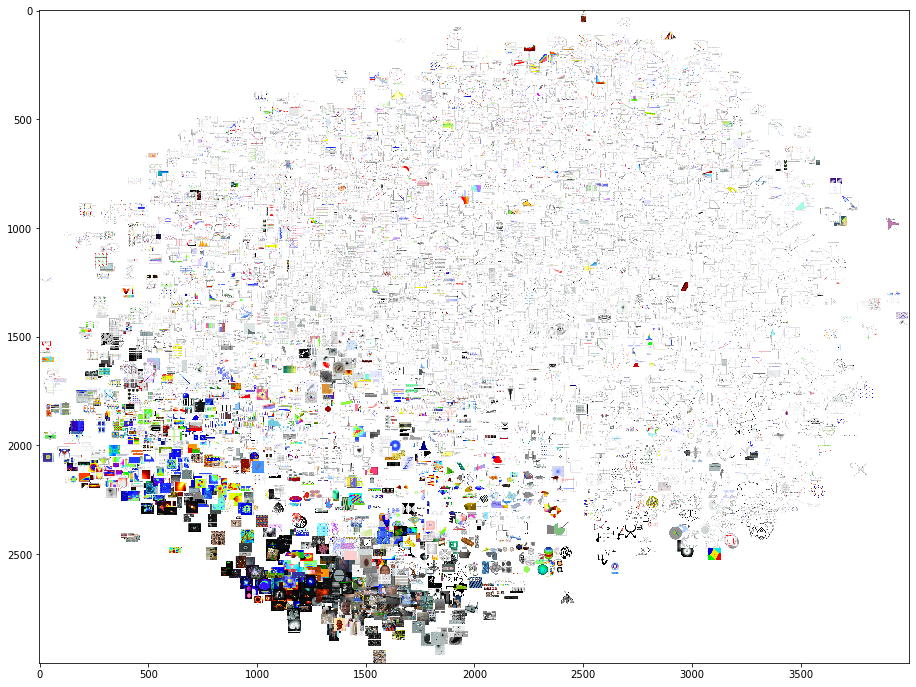

In [32]:
features = np.array(features_load[:num_samples])

print("----- running pca across features -----")
print("features shape:", features.shape)
print("number of samples: ", np.size(features, 0))
pca = PCA(n_components=min(np.size(features,0), 300))
pca.fit(features)

pca_features = pca.transform(features)

print("----- pca done -----")
print("----- running tSNE -----")

X = np.array(pca_features)
print("X shape:", X.shape)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=perp, verbose=2, n_iter=num_iterations).fit_transform(X)
print("t-SNE shape:",tsne.shape)

print("----- tSNE done -----")

# write pickle
# print("writing tsne pickle")

# ts = time.time()
# st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d_%H-%M-%S')

# filename = "tSNE_cuda_" + category + "_" + year + "_n" + str(num_iterations) + "_p" + str(perp) + "_" + st
# print(filename + ".pickle")

filename = "tSNE_cuda_random_x{}_{}".format(num_samples, time.strftime("%Y%m%d-%H%M%S"))

# with open(filename + ".pickle", "wb") as write_file:
#     pickle.dump([images, tsne], write_file)
#     write_file.close()

# normalise points
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
print("tx shape:", tx.shape)
print("ty shape:", ty.shape)
print("tx sample:", tx[:50])
print("ty sample:", ty[:50])

width = 4000
height = 3000
max_dim = 60

print("----- creating image from tiles -----")

full_image = Image.new('RGBA', (width, height))
img_dir = "/mnt/hd2/images/all/"
counter = 0
for img, x, y in zip(images, tx, ty):
    print("count:", counter)
    counter += 1
    tile = Image.open(img_dir + img)
    tw = tile.width
    print("tw:", tw)
    th = tile.height
    print("th:", th)
    print(img)
    print("tile dimensions: x={} y={}".format(tile.width, tile.height))
    if tw < 10000 and th < 10000:
        rs = max(1, tw/max_dim, th/max_dim)
        tile = tile.resize((int(tw/rs), int(th/rs)), Image.ANTIALIAS)
        place_x = int((width-max_dim)*x)
        place_y = int((height-max_dim)*y)
        print("image placement: x={} y={}".format(place_x, place_y))
        full_image.paste(tile, (place_x, place_y), mask=tile.convert('RGBA'))
#             else:
#                 print("tile width or height too big?")
        print("-----")

plt.figure(figsize = (16,12))
imshow(full_image)

print("saved file: " + filename + ".png")
full_image.save(filename + ".png")
print("----- finished! file saved -----")


RasterFairy - grid

In [41]:
nx = 125
ny = 40

In [42]:
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

NameError: name 'tsne' is not defined

In [39]:
nx = 250
ny = 200
# nx = 125
# ny = 80

In [58]:
nx = 10
ny = 30

In [59]:
grid_assignment = rasterfairy.transformPointCloud2D(embedding, target=(nx, ny))

In [63]:
nx = 400
ny = 250

In [64]:
grid_assignment = rasterfairy.transformPointCloud2D(embedding, target=(nx, ny))

saved file: umap_random_grid_x300_20201008-124649.png
----- finished! file saved -----


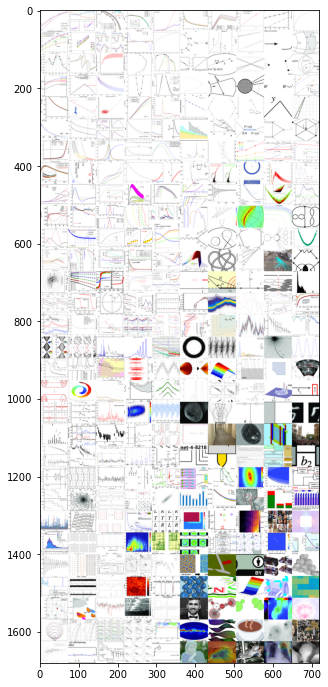

In [60]:
tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img_dir + img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

plt.figure(figsize = (16,12))
imshow(grid_image)

filename = "umap_random_grid_x{}_{}.png".format(num_samples, time.strftime("%Y%m%d-%H%M%S"))

print("saved file: " + filename)
grid_image.save(filename)
print("----- finished! file saved -----")

## UMAP

In [10]:
import umap

In [46]:
features = np.array(features_load[:num_samples])

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(features)

In [47]:
print(embedding)

[[-1.3123885  -0.1510628 ]
 [-1.7015833  -2.6113265 ]
 [ 0.26477292 -3.1888154 ]
 [ 0.69799376 -3.8160021 ]
 [-0.25996932 -1.1421907 ]
 [ 0.4349639  -0.40525362]
 [-1.7122405  -2.3124158 ]
 [ 3.0182247  -0.7009255 ]
 [-0.10836852 -1.9939553 ]
 [ 0.28981876 -2.0608332 ]
 [ 0.3416923  -0.98456436]
 [ 0.0438717  -1.983862  ]
 [ 0.7884993  -3.1489527 ]
 [-0.6748816  -1.1805408 ]
 [-1.1710777   0.3145621 ]
 [ 0.3068837   0.3959618 ]
 [ 0.7266785   0.3011151 ]
 [-0.96875733 -1.7756505 ]
 [ 1.5393987  -2.0032825 ]
 [-0.9180054  -3.1107898 ]
 [ 2.838044   -0.41213527]
 [-1.1092255   0.5544103 ]
 [ 1.6348674  -0.90086335]
 [ 2.3264384  -2.855784  ]
 [ 1.7439972   0.48742446]
 [-1.8709002  -0.58845854]
 [ 1.4710325  -1.1731646 ]
 [ 1.9266552  -1.109388  ]
 [ 2.2557716  -1.6659839 ]
 [ 0.9350236  -0.58273584]
 [ 1.3883176  -0.06717178]
 [ 0.20259824  0.41962415]
 [-1.1981678  -2.3794088 ]
 [ 2.9584122  -1.0363786 ]
 [ 1.1224216  -3.8278258 ]
 [ 0.0862129  -3.35206   ]
 [ 2.1705155  -0.7759068 ]
 

In [48]:
embedding.shape

(300, 2)

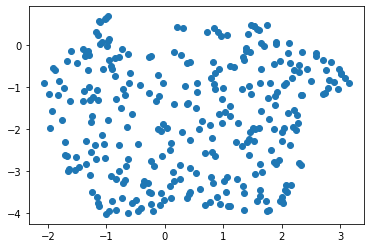

In [49]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])

tx shape: (300,)
ty shape: (300,)
tx sample: [0.14392568 0.06919264 0.44677168 0.5299586  0.34601086 0.47945172
 0.06714625 0.97548866 0.3751212  0.451581   0.4615417  0.4043543
 0.5473375  0.26633957 0.17106013 0.45485777 0.5354667  0.20990962
 0.6915249  0.21965499 0.9408903  0.18293698 0.7098568  0.84265196
 0.7308119  0.03668047 0.67839724 0.7658858  0.82908267 0.575473
 0.6625144  0.43483296 0.16585831 0.96400344 0.6114571  0.41248465
 0.8127117  0.12831238 0.23282176 0.6027114  0.86408776 0.6906511
 0.20210268 0.5765406  0.7831434  0.6557433  0.9516612  0.5710604
 0.15532677 0.63010645]
ty sample: [0.82249224 0.2998148  0.1771286  0.04388419 0.61192936 0.76848996
 0.36331767 0.7056751  0.43097392 0.41676584 0.64541674 0.43311822
 0.18559732 0.60378194 0.9214132  0.93870634 0.9185564  0.47735226
 0.42899233 0.19370495 0.7670279  0.9723684  0.66319877 0.24788037
 0.95813733 0.7295685  0.605349   0.6188982  0.50065064 0.7307843
 0.8403147  0.9437334  0.34908518 0.6344089  0.04137228

image placement: x=1304 y=608
-----
count: 98
tw: 1006
th: 475
1328138.jpg
tile dimensions: x=1006 y=475
image placement: x=1314 y=284
-----
count: 99
tw: 755
th: 512
9327446.jpg
tile dimensions: x=755 y=512
image placement: x=420 y=1025
-----
count: 100
tw: 715
th: 512
2459583.jpg
tile dimensions: x=715 y=512
image placement: x=902 y=138
-----
count: 101
tw: 671
th: 512
4323996.jpg
tile dimensions: x=671 y=512
image placement: x=198 y=401
-----
count: 102
tw: 839
th: 512
8184452.jpg
tile dimensions: x=839 y=512
image placement: x=1007 y=429
-----
count: 103
tw: 857
th: 512
6787601.jpg
tile dimensions: x=857 y=512
image placement: x=371 y=493
-----
count: 104
tw: 781
th: 512
6115348.jpg
tile dimensions: x=781 y=512
image placement: x=727 y=148
-----
count: 105
tw: 717
th: 512
9007464.jpg
tile dimensions: x=717 y=512
image placement: x=248 y=871
-----
count: 106
tw: 538
th: 512
4937642.jpg
tile dimensions: x=538 y=512
image placement: x=335 y=1269
-----
count: 107
tw: 256
th: 256
631261

image placement: x=1279 y=903
-----
count: 196
tw: 104
th: 128
793324.jpg
tile dimensions: x=104 y=128
image placement: x=1900 y=929
-----
count: 197
tw: 643
th: 512
1241818.jpg
tile dimensions: x=643 y=512
image placement: x=745 y=98
-----
count: 198
tw: 607
th: 442
6350957.jpg
tile dimensions: x=607 y=442
image placement: x=1235 y=481
-----
count: 199
tw: 512
th: 921
266130.jpg
tile dimensions: x=512 y=921
image placement: x=851 y=1128
-----
count: 200
tw: 734
th: 512
7425880.jpg
tile dimensions: x=734 y=512
image placement: x=1282 y=582
-----
count: 201
tw: 642
th: 512
7848432.jpg
tile dimensions: x=642 y=512
image placement: x=524 y=4
-----
count: 202
tw: 536
th: 512
4874934.jpg
tile dimensions: x=536 y=512
image placement: x=299 y=691
-----
count: 203
tw: 701
th: 512
1689104.jpg
tile dimensions: x=701 y=512
image placement: x=573 y=101
-----
count: 204
tw: 520
th: 512
6615357.jpg
tile dimensions: x=520 y=512
image placement: x=1468 y=385
-----
count: 205
tw: 737
th: 376
3534890.jp

-----
count: 292
tw: 512
th: 532
5564994.jpg
tile dimensions: x=512 y=532
image placement: x=1483 y=578
-----
count: 293
tw: 512
th: 560
5611853.jpg
tile dimensions: x=512 y=560
image placement: x=365 y=1024
-----
count: 294
tw: 512
th: 611
4492014.jpg
tile dimensions: x=512 y=611
image placement: x=1843 y=1027
-----
count: 295
tw: 760
th: 512
8985437.jpg
tile dimensions: x=760 y=512
image placement: x=161 y=799
-----
count: 296
tw: 1932
th: 512
6547801.jpg
tile dimensions: x=1932 y=512
image placement: x=1370 y=1185
-----
count: 297
tw: 450
th: 56
603428.jpg
tile dimensions: x=450 y=56
image placement: x=1558 y=738
-----
count: 298
tw: 512
th: 608
8456411.jpg
tile dimensions: x=512 y=608
image placement: x=668 y=376
-----
count: 299
tw: 524
th: 512
2771747.jpg
tile dimensions: x=524 y=512
image placement: x=423 y=92
-----
saved file: umap_random_x300_20201008-124316.png
----- finished! file saved -----


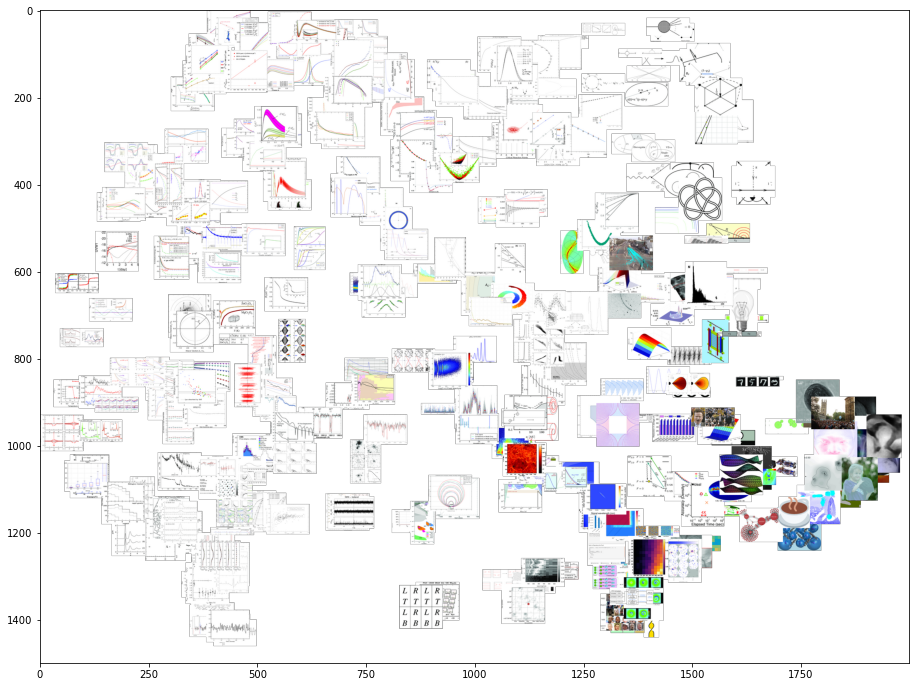

In [50]:
filename = "umap_random_x{}_{}".format(num_samples, time.strftime("%Y%m%d-%H%M%S"))

# with open(filename + ".pickle", "wb") as write_file:
#     pickle.dump([images, tsne], write_file)
#     write_file.close()

# normalise points
tx, ty = embedding[:,0], embedding[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
print("tx shape:", tx.shape)
print("ty shape:", ty.shape)
print("tx sample:", tx[:50])
print("ty sample:", ty[:50])

# width = 4000
# height = 3000
# max_dim = 60

width = 2000
height = 1500
max_dim = 100

print("----- creating image from tiles -----")

full_image = Image.new('RGBA', (width, height))
img_dir = "/mnt/hd2/images/all/"
counter = 0
for img, x, y in zip(images, tx, ty):
    print("count:", counter)
    counter += 1
    tile = Image.open(img_dir + img)
    tw = tile.width
    print("tw:", tw)
    th = tile.height
    print("th:", th)
    print(img)
    print("tile dimensions: x={} y={}".format(tile.width, tile.height))
    if tw < 10000 and th < 10000:
        rs = max(1, tw/max_dim, th/max_dim)
        tile = tile.resize((max(1, int(tw/rs)), max(1,int(th/rs))), Image.ANTIALIAS)
        place_x = int((width-max_dim)*x)
        place_y = int((height-max_dim)*y)
        print("image placement: x={} y={}".format(place_x, place_y))
        full_image.paste(tile, (place_x, place_y), mask=tile.convert('RGBA'))
#             else:
#                 print("tile width or height too big?")
        print("-----")

plt.figure(figsize = (16,12))
imshow(full_image)

print("saved file: " + filename + ".png")
full_image.save(filename + ".png")
print("----- finished! file saved -----")


more customised?

In [22]:
reducer = umap.UMAP(random_state=42)
reducer.fit(features)

/home/rte/code/anaconda3/envs/umap/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../code/anaconda3/envs/umap/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

In [ ]:
# UMAP(a=None, angular_rp_forest=False, b=None,
#      force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
#      local_connectivity=1.0, low_memory=False, metric='euclidean',
#      metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
#      n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
#      output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
#      set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
#      target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
#      transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [24]:
embedding = reducer.transform(features)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(5000, 2)

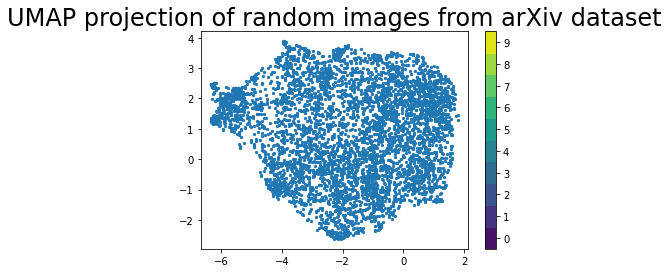

In [27]:
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of random images from arXiv dataset', fontsize=24);